<a href="https://colab.research.google.com/github/rulocastellanos/practice_data_science_ml/blob/main/Time_Series_Forecasting_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Time Series Forecasting with XGBoost](https://www.youtube.com/watch?v=vV12dGe_Fho)

[Data in Kaggle](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt/input)




In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/PJME_hourly.csv')

Exploring the dataset we know that the data is from 2002 to 2018.

In [5]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [6]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [7]:
# Setting the index to be the Datetime

df = df.set_index('Datetime')

In [8]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


Visualize

In [9]:
#From seaborn import color palette
color_pal = sns.color_palette()

<Axes: title={'center': 'PJEM Energy use in MW'}, xlabel='Datetime'>

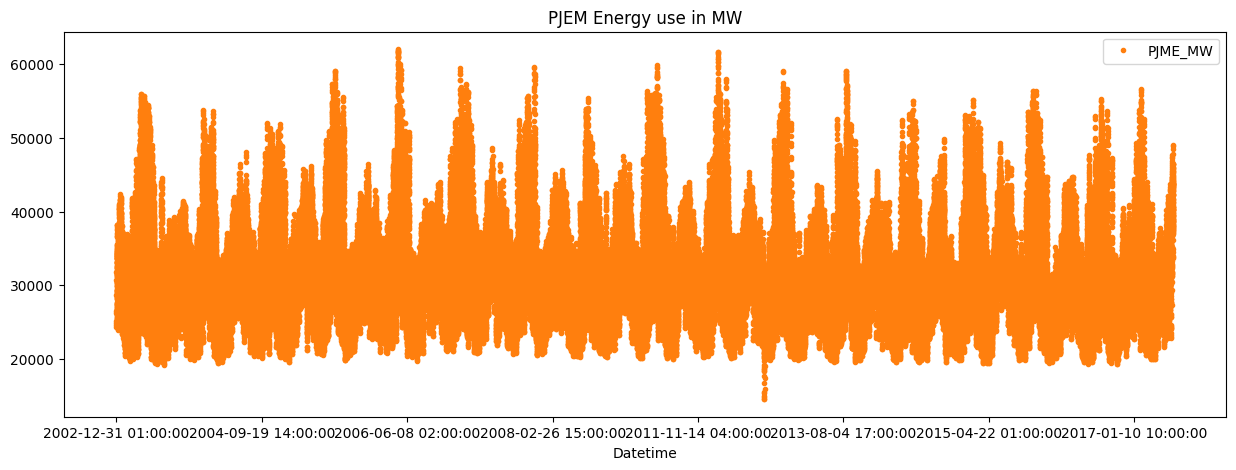

In [10]:
df.plot(style = '.',
        figsize=(15,5),
        color = color_pal[1],
        title = 'PJEM Energy use in MW')

In [11]:
#Transforming from index object to index datetime
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJEM Energy use in MW'}, xlabel='Datetime'>

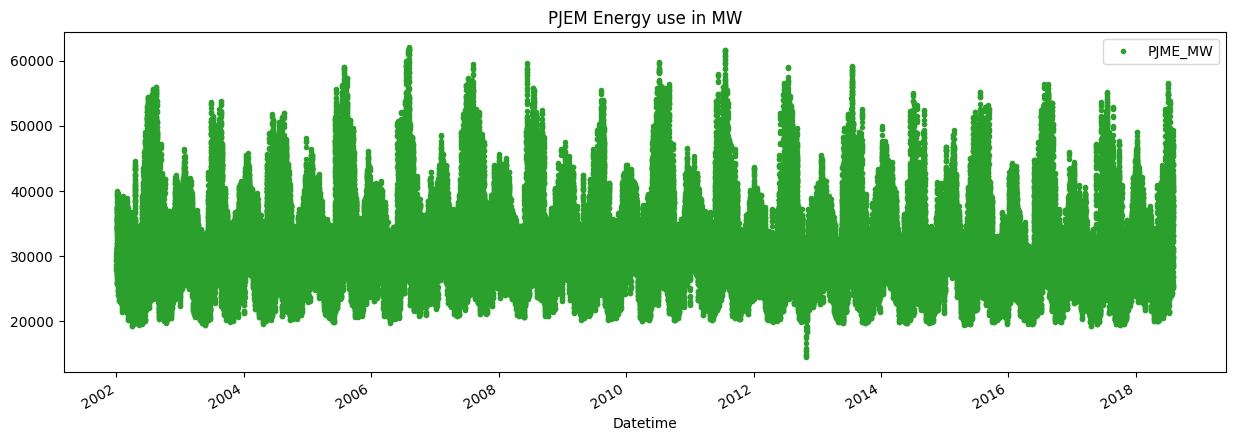

In [12]:
df.plot(style = '.',
        figsize=(15,5),
        color = color_pal[2],
        title = 'PJEM Energy use in MW')

Train test *split*

Based on january 2015

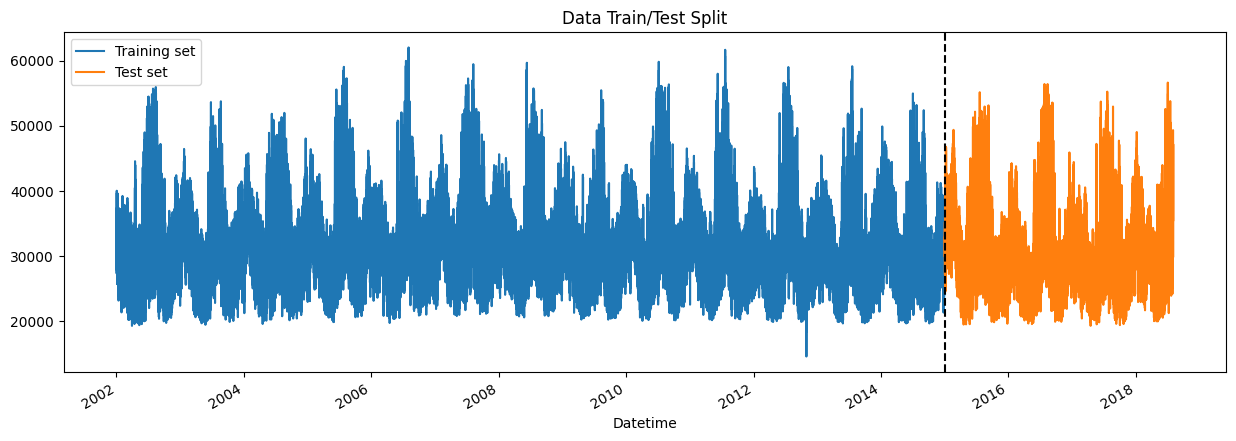

In [13]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label = 'Training set', title = 'Data Train/Test Split')
test.plot(ax=ax, label = 'Testing set')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training set', 'Test set'])
plt.show()


How does 1 week of data looks like?

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

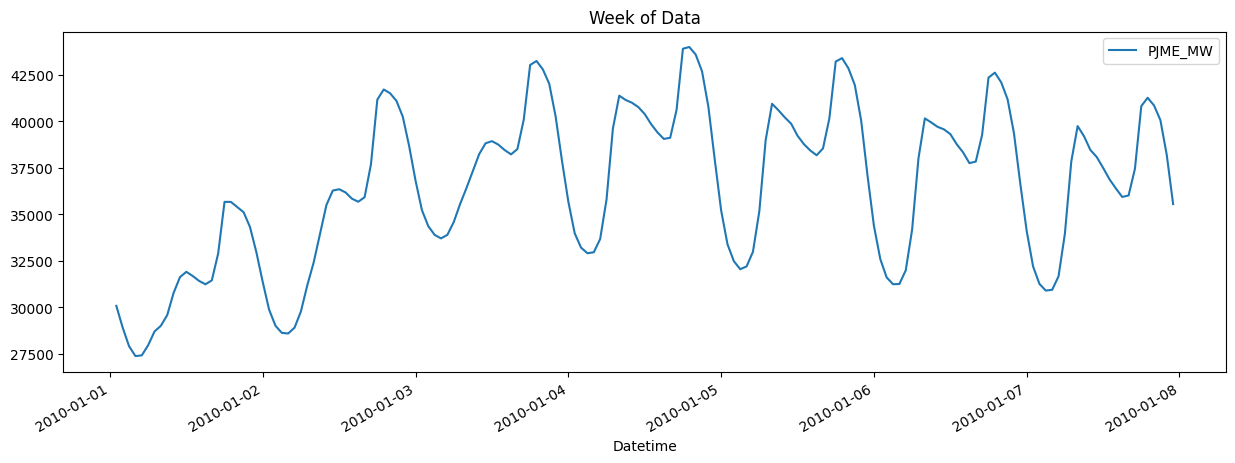

In [14]:
df.loc[(df.index > '01-01-2010') &
       (df.index < '01-08-2010')].plot(figsize=(15,5),
                                       title = 'Week of Data')

Feauture creation

In [15]:
def create_features (df):
  '''
  Create time series features based on time series index.
  '''
  df['hour'] = df.index.hour
  df['day_of_week'] = df.index.day_of_week
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['day_of_year'] = df.index.day_of_year
  return df

In [16]:
df = create_features (df)

In [17]:
df

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


Visualize our Feuture to Target Relationship

<ipython-input-18-48d1f94a0f8c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = 'hour', y = 'PJME_MW', palette=palette)
<ipython-input-18-48d1f94a0f8c>:5: UserWarning: 
The palette list has fewer values (6) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data = df, x = 'hour', y = 'PJME_MW', palette=palette)


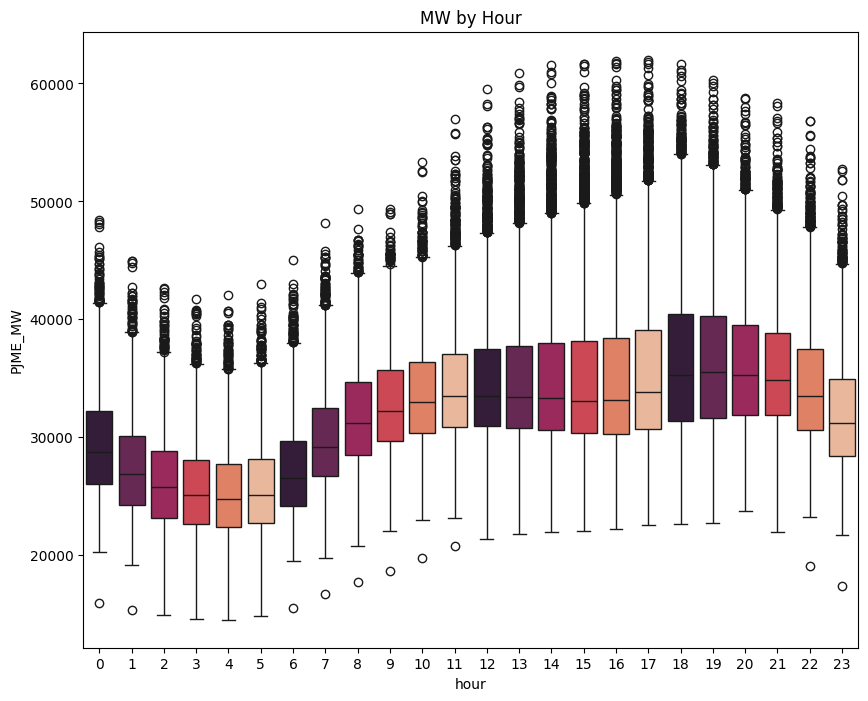

In [18]:
#By hour
#We can see that there is more consumption in the afternoon
palette = sns.color_palette("rocket")
fig, ax = plt.subplots(figsize =(10,8))
sns.boxplot(data = df, x = 'hour', y = 'PJME_MW', palette=palette)
ax.set_title('MW by Hour')
plt.show()

<ipython-input-19-441ad5e65e1c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = 'month', y = 'PJME_MW', palette=palette)
<ipython-input-19-441ad5e65e1c>:5: UserWarning: 
The palette list has fewer values (6) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data = df, x = 'month', y = 'PJME_MW', palette=palette)


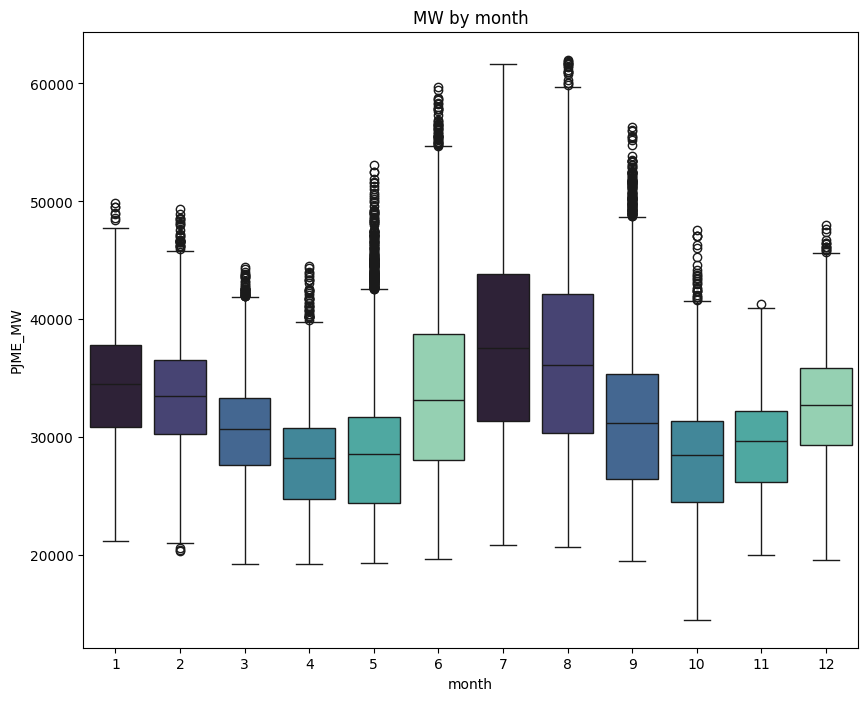

In [19]:
#By month
#We can see that there is more consumption in the winte (heater) and in the summer (AC)
palette = sns.color_palette("mako")
fig, ax = plt.subplots(figsize =(10,8))
sns.boxplot(data = df, x = 'month', y = 'PJME_MW', palette=palette)
ax.set_title('MW by month')
plt.show()

Create our model

In [20]:
#more penalty to the predictions that are way off
from sklearn.metrics import mean_squared_error

In [21]:
train = create_features(train)
test = create_features(test)

<ipython-input-15-eeec1976c3fe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-15-eeec1976c3fe>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df.index.day_of_week
<ipython-input-15-eeec1976c3fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [22]:
df.columns

Index(['PJME_MW', 'hour', 'day_of_week', 'quarter', 'month', 'year',
       'day_of_year'],
      dtype='object')

In [23]:
FEATURES = ['hour', 'day_of_week', 'quarter', 'month', 'year','day_of_year']
TARGET = ['PJME_MW']

In [24]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [25]:
# The error squared is being reduced in both train and test
# We need to change learning rate to stop overfitting
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,
                       learning_rate = 0.01)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100 #verbose every 100 trees,
        )

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Feature importance after taining our model

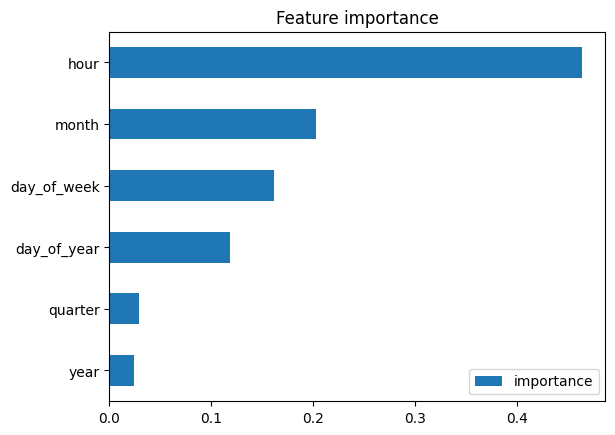

In [26]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])

fi.sort_values('importance').plot(kind = 'barh',
                                  title = 'Feature importance')
plt.show()

Forecast on test

In [27]:
test['prediction'] = reg.predict(X_test)

<ipython-input-27-33b5c0e814cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


In [28]:
df = df.merge(test['prediction'],
         how = 'left',
         left_index = True,
         right_index = True)

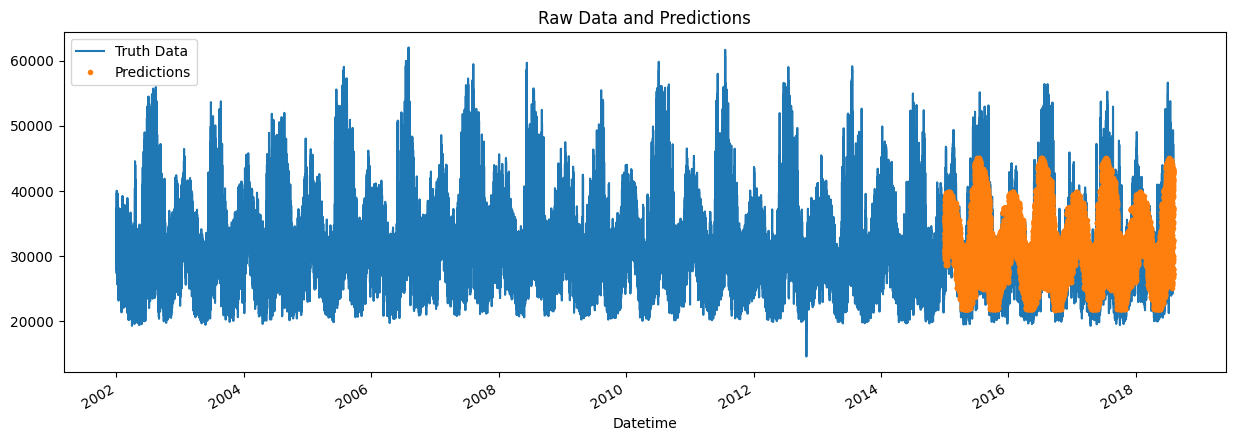

In [29]:
ax = df['PJME_MW'].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

In [30]:
test.columns

Index(['PJME_MW', 'hour', 'day_of_week', 'quarter', 'month', 'year',
       'day_of_year', 'prediction'],
      dtype='object')

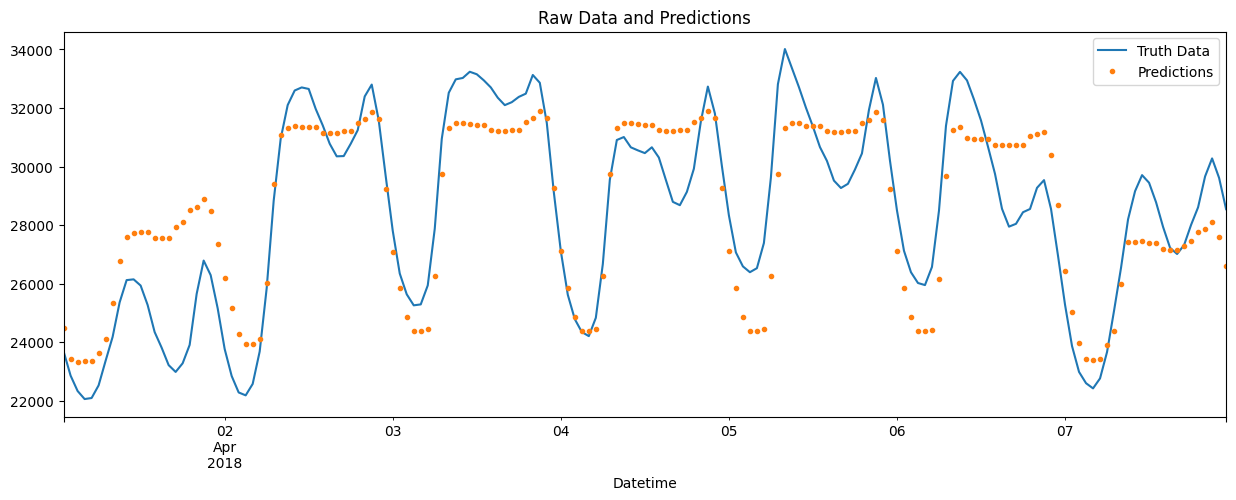

In [31]:
# Plotting the preddiction of a single week
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize = (15,5), title = 'Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

In [32]:
score = np.sqrt(mean_squared_error(test['PJME_MW'],
                   test['prediction']))

print(f'RSME Score on test set: {score:0.2f}')

RSME Score on test set: 3741.03


Calculate the error

Look at best and worst predicted days.



In [33]:
duplicates = test.columns[test.columns.duplicated()]
print("Duplicate columns:", duplicates)

Duplicate columns: Index([], dtype='object')


In [35]:
test[TARGET]

,PJME_MW
Datetime,
2015-01-01 00:00:00,32802.0
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [36]:
test['prediction']

,prediction
Datetime,
2015-01-01 00:00:00,32393.351562
2015-12-31 01:00:00,29040.167969
2015-12-31 02:00:00,27877.017578
2015-12-31 03:00:00,27576.720703
2015-12-31 04:00:00,27576.720703
...,...
2018-01-01 20:00:00,38623.246094
2018-01-01 21:00:00,38495.484375
2018-01-01 22:00:00,36229.527344


In [38]:
test['error'] = np.abs(test['PJME_MW']- test['prediction'])

<ipython-input-38-82c4a792a1d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test['PJME_MW']- test['prediction'])


In [39]:
test['date'] = test.index.date

<ipython-input-39-f26c019bf92f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index.date


In [42]:
# Worst days in 2016
test.groupby(['date'])['error'].mean()\
.sort_values(ascending= False).head()

,error
date,
2016-08-13,13829.866211
2016-08-14,13577.304362
2016-09-10,11235.855143
2016-09-09,11032.220215
2016-08-12,10667.820312


In [43]:
# Worst days in 2016
test.groupby(['date'])['error'].mean()\
.sort_values(ascending= True).head()

,error
date,
2016-12-30,395.436442
2017-10-24,413.885824
2016-10-27,440.053141
2016-04-04,440.223877
2017-05-02,453.738688
